In [1]:
import os, re, shutil, json, time
import jieba, numpy
import string, gensim
import threading
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec
from collections import Counter
from tqdm import tqdm

In [2]:
def extract_jfull(filename: str):
    with open(os.path.join(dirpath + '/drug_case', filename), "r", encoding = 'UTF-8') as f:
        data = json.load(f)['JFULL']
        data = data.replace(' ', '').replace('　', '')
    target0 = data.find('主文\r\n')
    # 如果案字帶有秩的，代表為社會秩序維護法的案子，並不在我們的管理範圍內
    if "秩" in filename: 
        return ""
    
    # 如果 JFULL 找不到主文，那就代表是 pdf 檔案
    # 暫定不處置
    if target0 != -1:
        target1 = []
        if data.find('事實及理由\r\n') != -1:
            target1.append(data.find('事實及理由\r\n', target0))
        if data.find('犯罪事實\r\n') != -1:
            target1.append(data.find('犯罪事實\r\n', target0))
        if data.find('理由\r\n') != -1:
            target1.append(data.find('理由\r\n', target0))
        if data.find('事實\r\n') != -1:
            target1.append(data.find('事實\r\n', target0))
        if data.find('中華民國') != -1:
            target1.append(data.find('中華民國', target0))
        target1 = min(target1)

        data = data[target1:].replace('\r\n', '')
        data = re.split(r'[，。「」（）『』【】；：、]', data)
        return data
    else:
        return ""

In [3]:
desktop = os.environ['USERPROFILE'] + '/Desktop'
dirpath = desktop + '/drug'

model = Doc2Vec.load(dirpath + "/drug_model.bin")
tmp = open(dirpath + '/label.txt', 'r', encoding = 'utf-8').readlines()
label = {}
train, train_label = [], []


for i in tqdm(tmp):
    filename, sencnt = i.split()
    label[filename] = sencnt
    try:
        check_text = ['製造', '販賣', '運輸', '持有', '施用', '引誘', '轉讓']
        beh = [0, 0, 0, 0, 0, 0, 0]
        text = extract_jfull(filename)
        for ii in range(len(check_text)):
            beh[ii] += (check_text[ii] in text) * 20
        # print(len(text), model.infer_vector(text).shape, np.array(beh).shape)
        text_vec = np.array(model.infer_vector(text).tolist() + beh)
        train.append(text_vec)
        train_label.append(sencnt)
    except:
        pass


100%|██████████████████████████████████████████████████████████████████████████| 24669/24669 [00:23<00:00, 1055.39it/s]


In [4]:
print(len(train), len(train_label))

23112 23112


In [5]:
train = np.array(train)
train_label = np.array(train_label)
print(train.shape, train_label.shape)

(23112, 307) (23112,)


## Create Dataset

In [6]:
import torch
from torch.utils.data import Dataset

class DrugDataset(Dataset):
    def __init__(self, X, y=None):
        self.data = torch.from_numpy(X).float()
        if y is not None:
            y = y.astype(np.float)
            self.label = torch.FloatTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)

Split the labeled data into a training set and a validation set, you can modify the variable `VAL_RATIO` to change the ratio of validation data.

In [7]:
VAL_RATIO = 0.1

percent = int(train.shape[0] * (1 - VAL_RATIO))
train_x, train_y, val_x, val_y = train[:percent], train_label[:percent], train[percent:], train_label[percent:]
print('Size of training set: {}'.format(train_x.shape))
print('Size of validation set: {}'.format(val_x.shape))

Size of training set: (20800, 307)
Size of validation set: (2312, 307)


Create a data loader from the dataset, feel free to tweak the variable `BATCH_SIZE` here.

In [8]:
BATCH_SIZE = 256

from torch.utils.data import DataLoader

train_set = DrugDataset(train_x, train_y)
val_set = DrugDataset(val_x, val_y)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) #only shuffle the training data
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

C:\Users\terry\AppData\Local\Temp/ipykernel_8588/604575324.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = y.astype(np.float)


Cleanup the unneeded variables to save memory.<br>

**notes: if you need to use these variables later, then you may remove this block or clean up unneeded variables later<br>the data size is quite huge, so be aware of memory usage in colab**

## Create Model

Define model architecture, you are encouraged to change and experiment with the model architecture.

In [9]:
import torch as t
import torch.nn as nn

class NN(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NN, self).__init__()

        self.net = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 1),
        )
        
    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x)

## Training

In [10]:
#check device
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(device)

cuda


Feel free to change the training parameters here.

In [14]:
model = NN(307).to(device)
model.device = device
if os.path.exists('best_weight.pth'):
    try:
        model.load_state_dict(torch.load('best_weight.pth'))
    except: 
        print('The model weight does not exist!')

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4, weight_decay = 1e-5)

# The number of training epochs.
n_epochs = 100
best_loss = 1000.0
train_loss_record = []
valid_loss_record = []

for epoch in range(n_epochs):
    model.train()
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):
        imgs, labels = batch
        logits = model(imgs.to(device))
        loss = criterion(torch.squeeze(logits), labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()
        # Compute the gradients for parameters.
        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        optimizer.step()

        # Record the loss and accuracy.
        train_loss.append(loss.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_loss_record.append(train_loss)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    valid_loss = []

    # Iterate the validation set by batches.
    for batch in tqdm(val_loader):
        imgs, labels = batch
        with torch.no_grad():
            logits = model(imgs.to(device))
        loss = criterion(torch.squeeze(logits), labels.to(device))
        valid_loss.append(loss.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_loss_record.append(valid_loss)
    
    if valid_loss < best_loss:
        print("best loss updated!")
        print(valid_loss, best_loss)
        best_model = model
        best_loss = valid_loss
        torch.save(model.state_dict(), "best_weight.pth")

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}")
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}")

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.38it/s]


best loss updated!
278.3745374202728 1000.0
[ Train | 001/100 ] loss = 136.34451
[ Valid | 001/100 ] loss = 278.37454


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.45it/s]


best loss updated!
218.70286312103272 278.3745374202728
[ Train | 002/100 ] loss = 135.87503
[ Valid | 002/100 ] loss = 218.70286


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.76it/s]


[ Train | 003/100 ] loss = 133.04411
[ Valid | 003/100 ] loss = 283.13107


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.11it/s]


[ Train | 004/100 ] loss = 127.93548
[ Valid | 004/100 ] loss = 318.08703


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.70it/s]


[ Train | 005/100 ] loss = 123.14475
[ Valid | 005/100 ] loss = 280.11505


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.45it/s]


[ Train | 006/100 ] loss = 125.81066
[ Valid | 006/100 ] loss = 257.70384


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.72it/s]


[ Train | 007/100 ] loss = 129.78985
[ Valid | 007/100 ] loss = 325.97491


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.49it/s]


[ Train | 008/100 ] loss = 124.39830
[ Valid | 008/100 ] loss = 304.21879


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.40it/s]


[ Train | 009/100 ] loss = 126.39509
[ Valid | 009/100 ] loss = 289.11477


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.45it/s]


[ Train | 010/100 ] loss = 122.62896
[ Valid | 010/100 ] loss = 298.11198


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.11it/s]


[ Train | 011/100 ] loss = 121.44123
[ Valid | 011/100 ] loss = 272.54046


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.40it/s]


[ Train | 012/100 ] loss = 118.76061
[ Valid | 012/100 ] loss = 268.84974


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.12it/s]


[ Train | 013/100 ] loss = 111.54848
[ Valid | 013/100 ] loss = 353.77798


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.47it/s]


[ Train | 014/100 ] loss = 108.29212
[ Valid | 014/100 ] loss = 274.25786


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.09it/s]


[ Train | 015/100 ] loss = 118.27190
[ Valid | 015/100 ] loss = 263.42555


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.74it/s]


[ Train | 016/100 ] loss = 109.23497
[ Valid | 016/100 ] loss = 249.52948


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 526.09it/s]


[ Train | 017/100 ] loss = 110.70696
[ Valid | 017/100 ] loss = 293.29101


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 555.05it/s]


[ Train | 018/100 ] loss = 108.89494
[ Valid | 018/100 ] loss = 312.83473


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 555.07it/s]


[ Train | 019/100 ] loss = 107.59367
[ Valid | 019/100 ] loss = 297.39469


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 525.86it/s]


[ Train | 020/100 ] loss = 105.62095
[ Valid | 020/100 ] loss = 318.25869


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.41it/s]


[ Train | 021/100 ] loss = 110.57785
[ Valid | 021/100 ] loss = 279.94967


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.66it/s]


[ Train | 022/100 ] loss = 102.24904
[ Valid | 022/100 ] loss = 303.55185


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.11it/s]


[ Train | 023/100 ] loss = 105.04322
[ Valid | 023/100 ] loss = 267.49465


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.72it/s]


[ Train | 024/100 ] loss = 103.20064
[ Valid | 024/100 ] loss = 291.23564


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.75it/s]


[ Train | 025/100 ] loss = 99.41689
[ Valid | 025/100 ] loss = 270.93401


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.66it/s]


[ Train | 026/100 ] loss = 104.33013
[ Valid | 026/100 ] loss = 262.87311


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.11it/s]


[ Train | 027/100 ] loss = 102.38589
[ Valid | 027/100 ] loss = 277.29134


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 555.08it/s]


[ Train | 028/100 ] loss = 103.50059
[ Valid | 028/100 ] loss = 294.40363


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.70it/s]


[ Train | 029/100 ] loss = 98.86454
[ Valid | 029/100 ] loss = 289.50439


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.40it/s]


[ Train | 030/100 ] loss = 100.71041
[ Valid | 030/100 ] loss = 275.13724


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 554.81it/s]


[ Train | 031/100 ] loss = 100.36163
[ Valid | 031/100 ] loss = 261.45176


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.32it/s]


[ Train | 032/100 ] loss = 97.08221
[ Valid | 032/100 ] loss = 312.12766


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.70it/s]


[ Train | 033/100 ] loss = 99.01183
[ Valid | 033/100 ] loss = 266.18831


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 588.03it/s]


[ Train | 034/100 ] loss = 94.80534
[ Valid | 034/100 ] loss = 277.57101


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 172.26it/s]


[ Train | 035/100 ] loss = 91.17276
[ Valid | 035/100 ] loss = 264.20462


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.68it/s]


[ Train | 036/100 ] loss = 95.41935
[ Valid | 036/100 ] loss = 283.51745


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 588.02it/s]


[ Train | 037/100 ] loss = 98.46732
[ Valid | 037/100 ] loss = 226.78935


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 555.35it/s]


[ Train | 038/100 ] loss = 93.31365
[ Valid | 038/100 ] loss = 260.30208


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.68it/s]


[ Train | 039/100 ] loss = 96.48642
[ Valid | 039/100 ] loss = 253.96968


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.43it/s]


[ Train | 040/100 ] loss = 97.49644
[ Valid | 040/100 ] loss = 330.20789


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.71it/s]


[ Train | 041/100 ] loss = 91.92062
[ Valid | 041/100 ] loss = 259.57784


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.42it/s]


[ Train | 042/100 ] loss = 90.25508
[ Valid | 042/100 ] loss = 304.17182


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.42it/s]


[ Train | 043/100 ] loss = 91.94441
[ Valid | 043/100 ] loss = 268.75500


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.68it/s]


[ Train | 044/100 ] loss = 89.51095
[ Valid | 044/100 ] loss = 267.17029


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.69it/s]


[ Train | 045/100 ] loss = 90.26068
[ Valid | 045/100 ] loss = 280.10097


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 555.32it/s]


[ Train | 046/100 ] loss = 88.08560
[ Valid | 046/100 ] loss = 309.01983


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 555.04it/s]


[ Train | 047/100 ] loss = 88.26302
[ Valid | 047/100 ] loss = 255.99505


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 555.05it/s]


[ Train | 048/100 ] loss = 90.47293
[ Valid | 048/100 ] loss = 240.74628


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.42it/s]


[ Train | 049/100 ] loss = 87.82920
[ Valid | 049/100 ] loss = 284.40251


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.71it/s]


[ Train | 050/100 ] loss = 89.82205
[ Valid | 050/100 ] loss = 249.50819


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 555.06it/s]


[ Train | 051/100 ] loss = 85.30899
[ Valid | 051/100 ] loss = 317.92697


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.69it/s]


[ Train | 052/100 ] loss = 85.93483
[ Valid | 052/100 ] loss = 246.28128


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.40it/s]


[ Train | 053/100 ] loss = 86.13369
[ Valid | 053/100 ] loss = 293.43074


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.68it/s]


[ Train | 054/100 ] loss = 87.95157
[ Valid | 054/100 ] loss = 258.52358


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.69it/s]


[ Train | 055/100 ] loss = 82.97022
[ Valid | 055/100 ] loss = 253.69942


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.68it/s]


[ Train | 056/100 ] loss = 85.43224
[ Valid | 056/100 ] loss = 272.27400


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.70it/s]


[ Train | 057/100 ] loss = 88.13417
[ Valid | 057/100 ] loss = 301.67867


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.43it/s]


[ Train | 058/100 ] loss = 86.88380
[ Valid | 058/100 ] loss = 255.58018


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.41it/s]


[ Train | 059/100 ] loss = 85.34384
[ Valid | 059/100 ] loss = 267.62547


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 555.07it/s]


[ Train | 060/100 ] loss = 84.46263
[ Valid | 060/100 ] loss = 245.26768


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 499.52it/s]


[ Train | 061/100 ] loss = 81.73090
[ Valid | 061/100 ] loss = 277.10732


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.43it/s]


[ Train | 062/100 ] loss = 87.21186
[ Valid | 062/100 ] loss = 270.37243


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.73it/s]


[ Train | 063/100 ] loss = 83.52010
[ Valid | 063/100 ] loss = 258.20011


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.71it/s]


[ Train | 064/100 ] loss = 83.92518
[ Valid | 064/100 ] loss = 265.41668


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.39it/s]


[ Train | 065/100 ] loss = 79.35349
[ Valid | 065/100 ] loss = 283.22027


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.71it/s]


[ Train | 066/100 ] loss = 82.07998
[ Valid | 066/100 ] loss = 256.73020


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.70it/s]


[ Train | 067/100 ] loss = 84.61599
[ Valid | 067/100 ] loss = 260.58192


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.70it/s]


[ Train | 068/100 ] loss = 86.55083
[ Valid | 068/100 ] loss = 285.48447


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 499.55it/s]


[ Train | 069/100 ] loss = 80.10049
[ Valid | 069/100 ] loss = 244.52478


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.73it/s]


[ Train | 070/100 ] loss = 83.45518
[ Valid | 070/100 ] loss = 257.60954


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.71it/s]


[ Train | 071/100 ] loss = 78.22931
[ Valid | 071/100 ] loss = 254.47701


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.71it/s]


[ Train | 072/100 ] loss = 79.20820
[ Valid | 072/100 ] loss = 278.28787


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.45it/s]


[ Train | 073/100 ] loss = 85.21394
[ Valid | 073/100 ] loss = 322.75801


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.73it/s]


[ Train | 074/100 ] loss = 76.99972
[ Valid | 074/100 ] loss = 266.36812


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.44it/s]


[ Train | 075/100 ] loss = 78.96776
[ Valid | 075/100 ] loss = 280.18908


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.43it/s]


[ Train | 076/100 ] loss = 79.60915
[ Valid | 076/100 ] loss = 268.51329


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.74it/s]


[ Train | 077/100 ] loss = 77.19372
[ Valid | 077/100 ] loss = 249.44945


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.67it/s]


[ Train | 078/100 ] loss = 77.49557
[ Valid | 078/100 ] loss = 256.71742


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.61it/s]


[ Train | 079/100 ] loss = 79.23591
[ Valid | 079/100 ] loss = 245.58001


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.45it/s]


[ Train | 080/100 ] loss = 80.12435
[ Valid | 080/100 ] loss = 260.14201


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.44it/s]


[ Train | 081/100 ] loss = 77.32698
[ Valid | 081/100 ] loss = 249.79764


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 178.41it/s]


[ Train | 082/100 ] loss = 77.83104
[ Valid | 082/100 ] loss = 252.43796


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.45it/s]


[ Train | 083/100 ] loss = 74.89908
[ Valid | 083/100 ] loss = 272.07125


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.44it/s]


[ Train | 084/100 ] loss = 76.91953
[ Valid | 084/100 ] loss = 252.65196


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.70it/s]


[ Train | 085/100 ] loss = 74.05069
[ Valid | 085/100 ] loss = 253.09222


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.68it/s]


[ Train | 086/100 ] loss = 78.01870
[ Valid | 086/100 ] loss = 236.26820


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.69it/s]


[ Train | 087/100 ] loss = 74.18781
[ Valid | 087/100 ] loss = 251.57453


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.41it/s]


[ Train | 088/100 ] loss = 74.84456
[ Valid | 088/100 ] loss = 263.52864


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.45it/s]


[ Train | 089/100 ] loss = 74.30811
[ Valid | 089/100 ] loss = 274.58230


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.44it/s]


[ Train | 090/100 ] loss = 77.29125
[ Valid | 090/100 ] loss = 261.61940


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.46it/s]


[ Train | 091/100 ] loss = 78.35520
[ Valid | 091/100 ] loss = 340.12045


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.47it/s]


[ Train | 092/100 ] loss = 74.97547
[ Valid | 092/100 ] loss = 238.63279


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.44it/s]


[ Train | 093/100 ] loss = 73.54903
[ Valid | 093/100 ] loss = 265.50640


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.14it/s]


[ Train | 094/100 ] loss = 74.92280
[ Valid | 094/100 ] loss = 231.46161


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.70it/s]


[ Train | 095/100 ] loss = 75.19427
[ Valid | 095/100 ] loss = 254.07389


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.71it/s]


[ Train | 096/100 ] loss = 71.63469
[ Valid | 096/100 ] loss = 260.20100


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.44it/s]


[ Train | 097/100 ] loss = 74.51677
[ Valid | 097/100 ] loss = 270.25563


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.71it/s]


[ Train | 098/100 ] loss = 74.30438
[ Valid | 098/100 ] loss = 263.23055


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 555.07it/s]


[ Train | 099/100 ] loss = 74.28261
[ Valid | 099/100 ] loss = 276.50998


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 588.03it/s]

[ Train | 100/100 ] loss = 71.38664
[ Valid | 100/100 ] loss = 278.73743


In [15]:
print(best_loss)

218.70286312103272


## Testing

Create a testing dataset, and load model from the saved checkpoint.

In [16]:
# create testing dataset
test_set = DrugDataset(val_x)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

Make prediction and output the result.

In [17]:
predict = []
model.eval() # set the model to evaluation mode
with torch.no_grad():
    for batch in tqdm(test_loader):
        imgs = batch
        with torch.no_grad():
            logits = model(imgs.to(device))
            answer = torch.squeeze(logits.cpu()).numpy().tolist()
    print(list(map(int, answer)))

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 333.12it/s]

[8, 9, 11, 4, 0, 24, 21, 4]


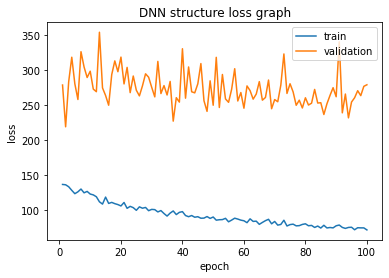

In [18]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

x = train_loss_record
y = valid_loss_record
epoch = [i for i in range(1, n_epochs + 1)]

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('DNN structure loss graph')
plt.plot(epoch, x, label = 'train')
plt.plot(epoch, y, label = 'validation')
plt.legend()
plt.show()